## Processing of Widefield data
Collected with  micromanager software

In [1]:
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari

from fly2p.viz.viz import myAxisTheme
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.microManagerUtils import getBasicMetadata, loadvolume

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
rootDir = "/Users/haberkernh/Dropbox (HHMI)/BeeImagingCoop"
subDir = "Widefield/210105_01_IPCs_gcamp6m_02"
dataDir = sep.join([rootDir, "Data",subDir])
rawTiff = "210105_01_GCamP6m_02.tif"
path2meta = dataDir+sep+'210105_01_GCamP6m_02_metadata.txt'

expName = rawTiff[:-4]

plotDir = sep.join([rootDir, 'Plots', subDir])
preprocDir = sep.join([rootDir, 'preproc', subDir])
print(dataDir)
print(expName)

if not exists(plotDir):
    makedirs(plotDir)

/Users/haberkernh/Dropbox (HHMI)/BeeImagingCoop/Data/Widefield/210105_01_IPCs_gcamp6m_02
210105_01_GCamP6m_02


#### (1) Read image tiff stack, metadata and package in xarray

In [3]:
basicMetadat = getBasicMetadata(path2meta)

#set manually  for now, maybe this info is somewhere in the metadata?
basicMetadat['xrange_um'] = 50
basicMetadat['yrange_um'] = 50
basicMetadat['CaCh'] = 0

basicMetadat

{'nCh': 1,
 'fpsscan': 5.0,
 'discardFBFrames': 0,
 'nDiscardFBFrames': 0,
 'fpv': 1,
 'nVols': 100,
 'stackZStepSize': 0.0,
 'scanVolumeRate': 5.0,
 'fovCoords': -1,
 'xrange_um': 50,
 'yrange_um': 50,
 'CaCh': 0}

In [4]:
stack = loadvolume(sep.join([dataDir,rawTiff]), basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

In [5]:
### cut out position of interest to avoid processing unnecessarily large images
imgStack = imgStack[:,:,700:1300, 700:1300]

In [19]:
viewer = napari.view_image(imgStack)

#### (2) Motion correction
Correct translation in x/y using phase correlation

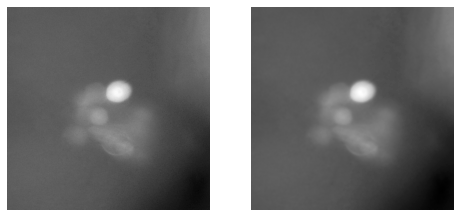

In [7]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [8]:
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

#### (3) Compute DFF

In [9]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

In [10]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)

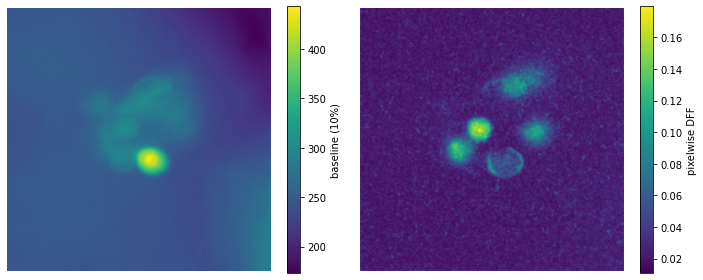

In [11]:
dffMP = np.max(dffStack,axis=0)

fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()

In [18]:
viewerdff = napari.view_image(dffStack)

#### (4) Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [13]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)

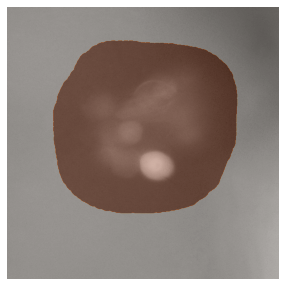

In [14]:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)

In [15]:
# Settings
from sklearn.cluster import KMeans

nclst = 4

toClust = dffStack[:,mask.data>0]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [16]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

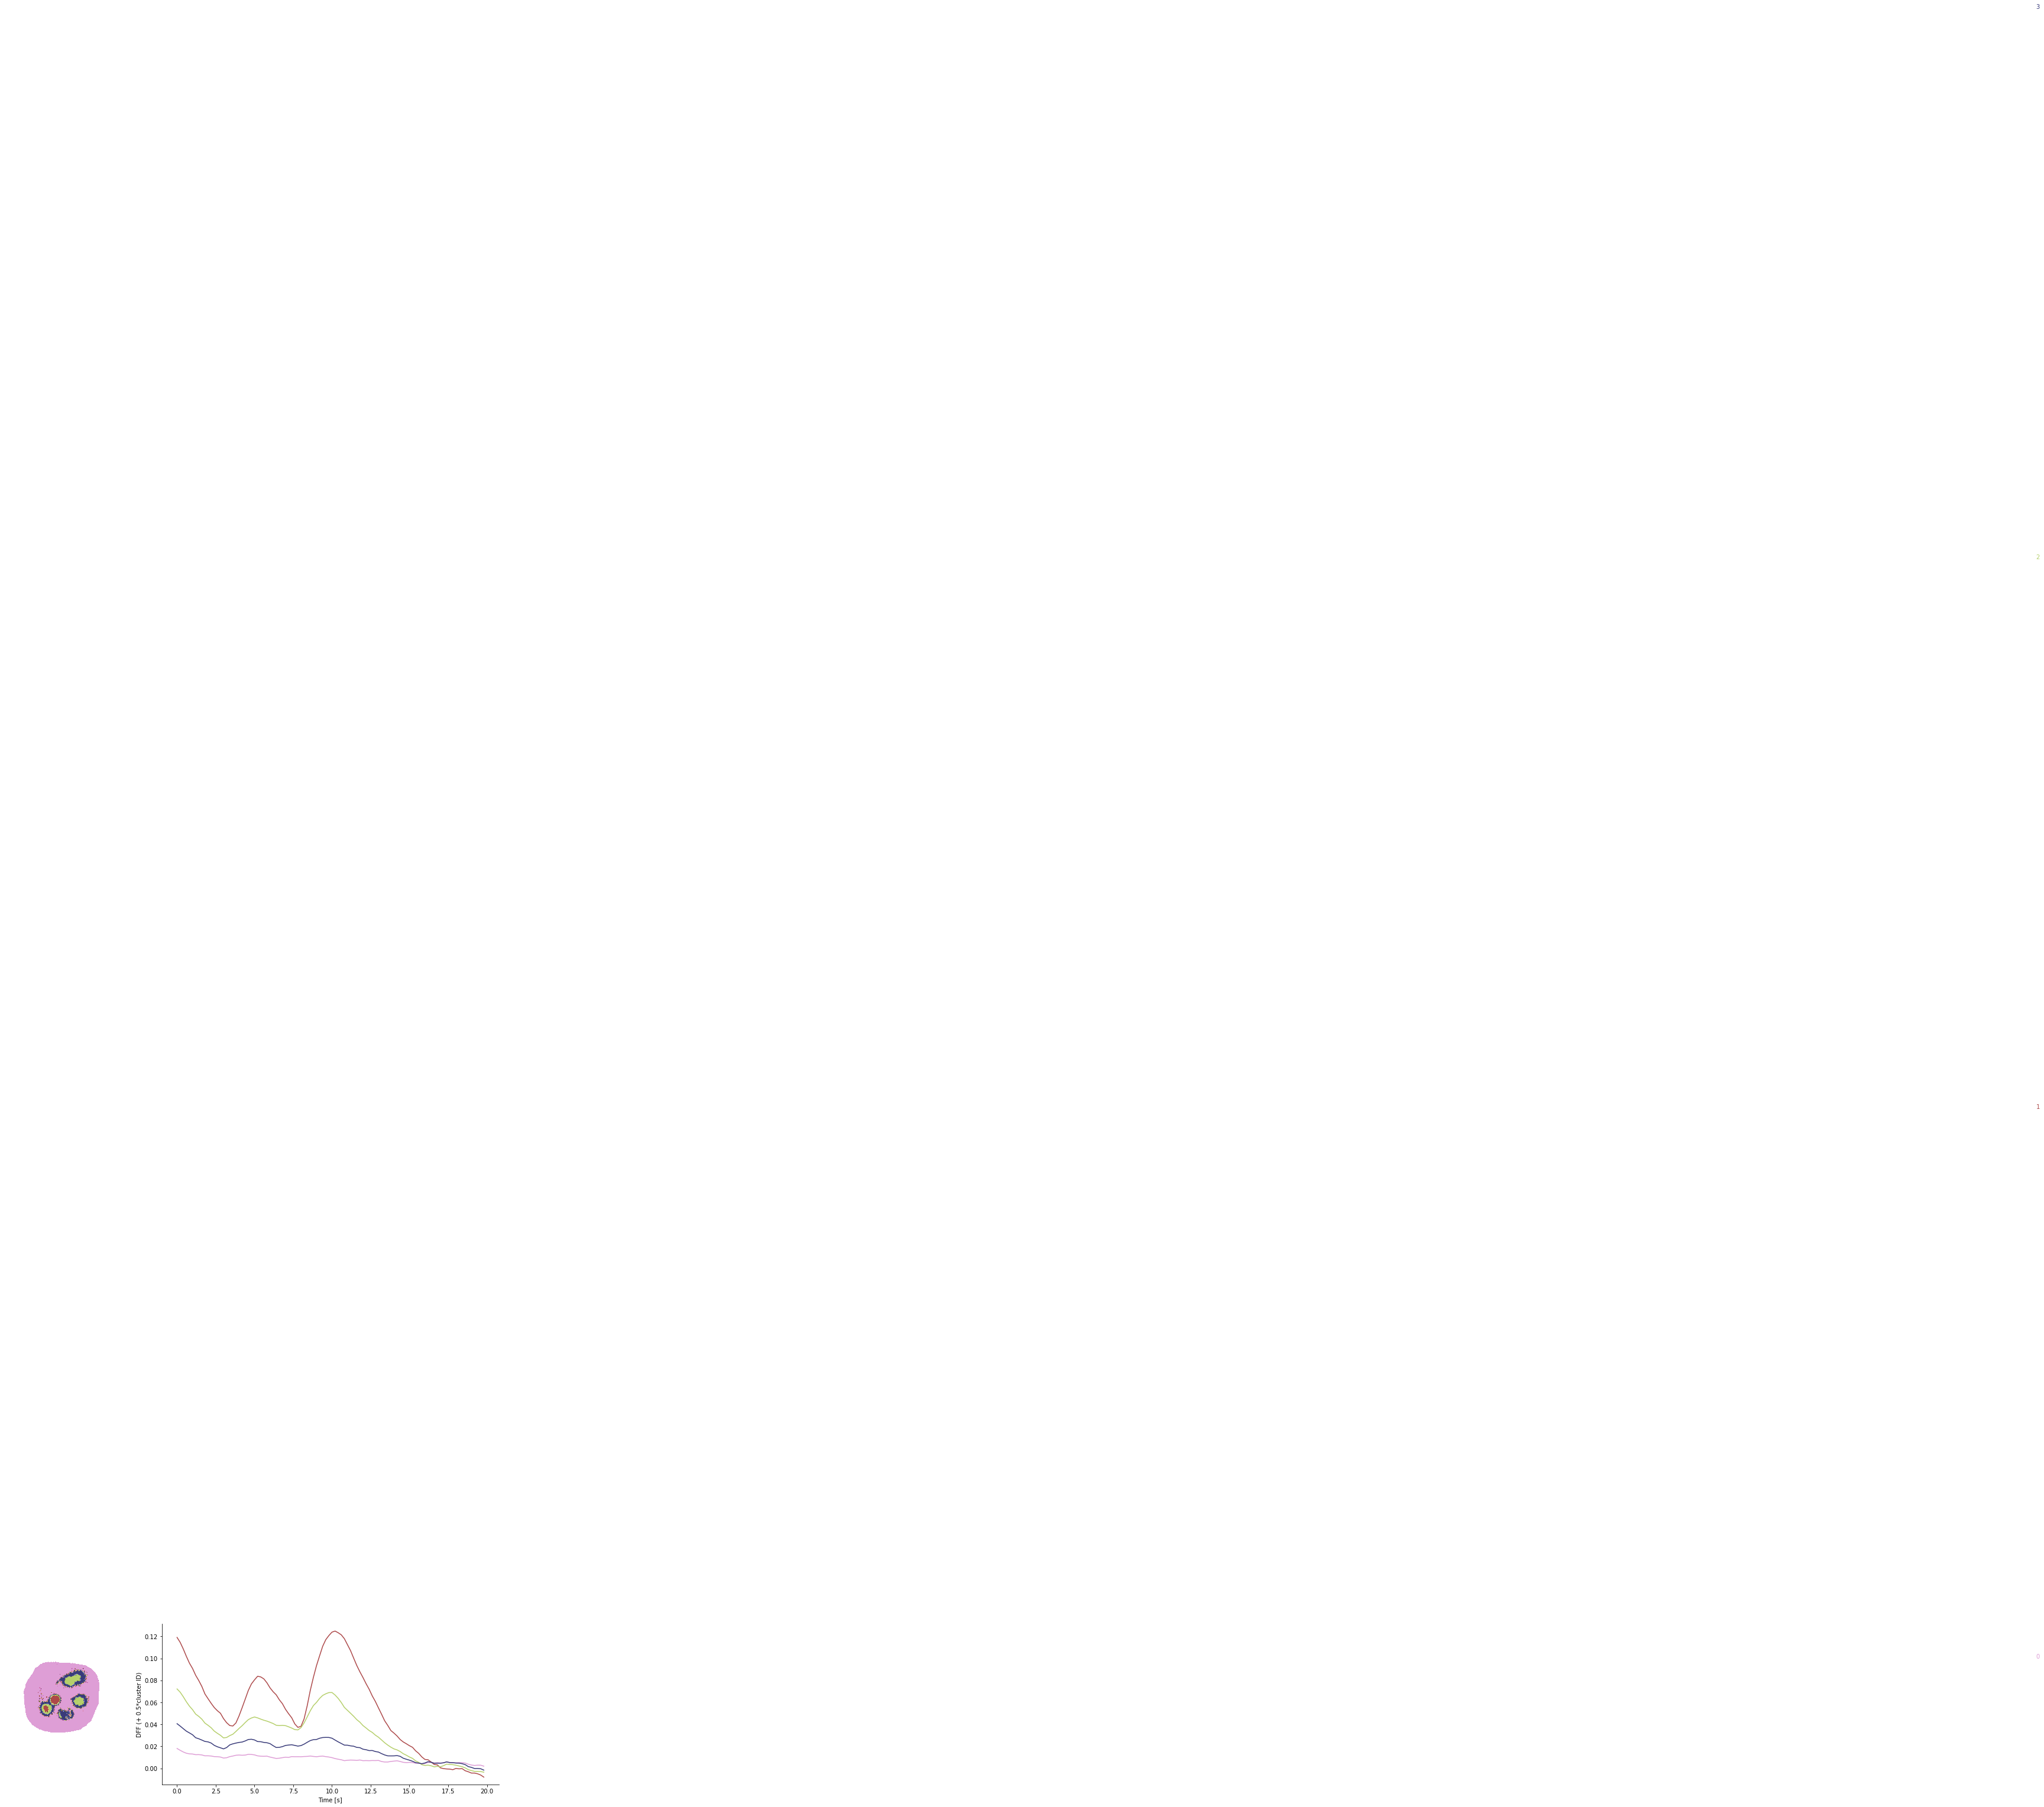

In [17]:
drawOffset = False
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    if drawOffset:
        axs[1].plot(time,centroids[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    else: 
        axs[1].plot(time,centroids[i], color=clstCMap.to_rgba(i+1))
    axs[1].text(120,i*0.5+.1,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])
fig.savefig(plotDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),expName])+'.pdf')